In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# We need to join the upper directory in order to access the local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import itertools
import json
import logging

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import scipy

from scipy.ndimage import uniform_filter1d
from scipy.io import loadmat, savemat

In [5]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 20

In [6]:
from pytdoa.mlat import exact, lls, nlls
from pytdoa.pytdoa import brutefoptim, nonlinoptim, linoptim
from pytdoa.util import generate_heatmap, generate_hyperbola
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT

In [7]:
fs = [40, 80, 100]
oversample = 1

In [8]:
# Reading the mat files
with open('comnets_data/gnbPositions.json') as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data['gnb0'],data['gnb1'],data['gnb2'],data['gnb3']])

with open('comnets_data/uePositions.json') as ue_file:
    data = json.load(ue_file)

UEs = np.array([data['ue0'],data['ue1'],data['ue2'],data['ue3'],data['ue4'],data['ue5']])
UEs

array([[1.8 , 6.07],
       [1.  , 6.07],
       [1.8 , 9.14],
       [3.28, 2.97],
       [0.58, 2.03],
       [5.28, 7.68]])

## Playing a bit with each of the positions (there are 6 in total)

In [214]:
POSITION = 2
FREQUENCY_MHZ = 100 # MHz
FREQUENCY = FREQUENCY_MHZ * 1e6

In [215]:
toa_measurements = pd.read_csv(f'comnets_data/experiments/exp{POSITION}/{FREQUENCY_MHZ}mhz.csv')
toa_measurements.drop(['Unnamed: 0',], axis=1, inplace=True)
toa_measurements.head(7)

,gNB0,P0,gNB1,P1,gNB2,P2,gNB3,P3
0,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
1,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
2,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
3,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
4,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
5,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf
6,0.0,-inf,0.0,-inf,0.0,-inf,0.0,-inf


In [216]:
toa_filt = toa_measurements.loc[~((toa_measurements == float('-inf')).any(axis=1))]
toa_filt.reset_index(drop=True, inplace=True)
toa_filt

,gNB0,P0,gNB1,P1,gNB2,P2,gNB3,P3
0,-4.0,-53.5,-5.0,-55.3,0.0,-57.7,0.0,-59.1
1,2.0,-59.5,-4.0,-53.4,0.0,-58.1,1.0,-59.0
2,-2.0,-54.1,0.0,-56.1,0.0,-56.7,1.0,-59.0
3,0.0,-57.4,-3.0,-53.4,1.0,-56.5,2.0,-59.7
4,-2.0,-54.3,1.0,-57.0,1.0,-56.3,2.0,-60.2
...,...,...,...,...,...,...,...,...
1343,148.0,-56.2,147.0,-53.1,151.0,-56.3,150.0,-60.3
1344,164.0,-56.2,163.0,-53.9,167.0,-57.1,166.0,-59.6
1345,194.0,-54.9,194.0,-57.4,198.0,-58.0,197.0,-60.0
1346,273.0,-55.9,272.0,-56.8,276.0,-58.9,275.0,-60.8


Text(0, 0.5, 'Measured ToA (samples)')

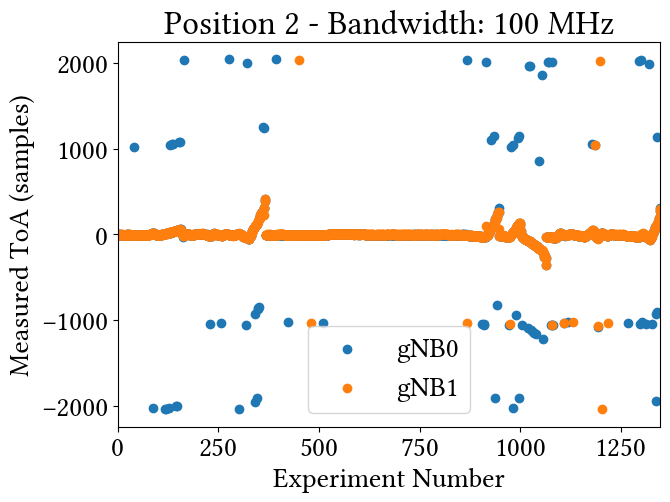

In [217]:
# Let's plot a bit the drift
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(x=np.arange(len(toa_filt)), y=toa_filt['gNB0'])
ax.scatter(x=np.arange(len(toa_filt)), y=toa_filt['gNB1'])

ax.legend(['gNB0','gNB1'])

ax.set_xlim([0,len(toa_filt)])

ax.set_title(f'Position {POSITION} - Bandwidth: {FREQUENCY_MHZ} MHz')
ax.set_xlabel('Experiment Number')
ax.set_ylabel('Measured ToA (samples)')

In [218]:
# Calculating the theoretical values
theoretical_toa = np.linalg.norm(UEs[POSITION] - gNBs, axis=1)
theoretical_tdoa_mat = theoretical_toa.reshape((-1,1)) - theoretical_toa
theoretical_tdoa = theoretical_tdoa_mat[np.triu_indices(4,k=1)]
theoretical_tdoa

array([ 0.1258737 , -5.10203104, -5.15136604, -5.22790474, -5.27723975,
       -0.049335  ])

In [234]:
EXPERIMENT = 200
#
gNB_toas = uniform_filter1d(toa_filt[["gNB0","gNB1","gNB2","gNB3"]].to_numpy(),5)
gNB_toas_selected = gNB_toas[EXPERIMENT,:]
gNB_tdoas_selected_mat = gNB_toas_selected.reshape((-1,1)) - gNB_toas_selected
selected_tdoa = gNB_tdoas_selected_mat[np.triu_indices(4,k=1)]
selected_tdoa = selected_tdoa / FREQUENCY * SPEED_OF_LIGHT
selected_tdoa

array([-2.99792458, -5.39626424, -7.19501899, -2.39833966, -4.19709441,
       -1.79875475])

In [235]:
linpos = linoptim(gNBs,selected_tdoa[0:4],input_type='xyz').squeeze()
print(f"Calculated Position - x: {linpos[0]:.4f} y: {linpos[1]:.4f}")
print(f"Real Position - x: {UEs[POSITION,0]:.4f} y: {UEs[POSITION,1]:.4f}")

Calculated Position - x: 0.5254 y: 6.5695
Real Position - x: 1.8000 y: 9.1400


In [236]:
combination_range = itertools.combinations(np.arange(len(gNBs)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

position_nlls = nonlinoptim(gNBs, selected_tdoa, combinations, num_dim=2, p0=np.mean(gNBs,axis=0), input_type="xyz", method="SLSQP")
position_nlls

array([[2.80674099, 8.55604383]])